In [1]:
import aesara.tensor as aet
import arviz
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy as sp
import seaborn as sns
import xarray
from scipy.special import expit as logistic

You are running the v4 development version of PyMC3 which currently still lacks key features. You probably want to use the stable v3 instead which you can either install via conda or find on the v3 GitHub branch: https://github.com/pymc-devs/pymc3/tree/v3


In [2]:
arviz.style.use("arviz-darkgrid")
RANDOM_SEED = 8927
np.random.seed(286)

## Data

In [87]:
polls = pd.read_csv(
    "../../data/polls_1st_round/tour1_complet_unitedfl.csv",
    index_col=0,
    parse_dates=["dateelection", "date"],
)
polls = (
    polls[(polls.dateelection == "2017-04-23") & (polls.sondage != "result")]
    .drop(["type", "dateelection", "abstention", "undecided",], axis=1)
    .set_index(["date", "sondage", "samplesize"])
    .sort_index()
)

In [18]:
COORDS = {
    "parties": ["farleft", "left", "green", "center", "right", "farright"],
    "parties_complete": [
        "farleft",
        "left",
        "green",
        "center",
        "right",
        "farright",
        "other",
    ],
}

In [88]:
# compute "other" category
polls = polls.rename(columns={col: col.split("nb")[1] for col in polls if col.startswith("nb")})[COORDS["parties"]]
polls["other"] = 100 - polls.sum(1)
polls = polls.reset_index(level="samplesize")

# cast as multinomial obs
polls[COORDS["parties_complete"]] = (polls[COORDS["parties_complete"]] / 100).mul(polls["samplesize"], axis=0).round().fillna(0).astype(int)
polls["samplesize"] = polls[COORDS["parties_complete"]].sum(1)
polls = polls.reset_index()
polls

,date,sondage,samplesize,farleft,left,green,center,right,farright,other
0,2016-11-17,Ifop,979,127,98,29,147,196,284,98
1,2016-11-25,Odoxa,845,101,68,17,110,270,186,93
2,2016-11-27,Harris,6092,792,548,183,853,1584,1462,670
3,2016-11-28,Kantar,1011,131,86,20,172,303,243,56
4,2016-11-28,Kantar,1011,121,76,20,152,293,233,116
...,...,...,...,...,...,...,...,...,...,...
146,2017-04-20,Elabe,1196,233,84,0,287,239,257,96
147,2017-04-20,Ifop,1901,352,133,0,466,370,428,152
148,2017-04-20,Ipsos,1400,266,105,0,336,266,308,119
149,2017-04-21,BVA,1134,221,91,0,261,215,261,85


In [ ]:
def dates_to_idx(timelist):
    """Convert datetimes to numbers in reference to a given date"""

    reference_time = timelist[0]
    t = (timelist - reference_time) / np.timedelta64(1, "M")

    return np.asarray(t)


time = dates_to_idx(d.index)
time[:10]

In [42]:
with pm.Model(coords=COORDS) as m_simple:
    n_cutpoints = len(COORDS["parties"])
    cut_base = pm.Normal("cut_base", mu=-1, sigma=3)
    cut_diffs = pm.HalfNormal("cut_diffs", sigma=2 / n_cutpoints, shape=n_cutpoints - 1)

    cutpoints = pm.Deterministic(
        "cutpoints",
        aet.concatenate([[cut_base], cut_base + cut_diffs.cumsum()]),
        dims="parties",
    )

    pm.OrderedMultinomial(
        "results",
        eta=0,
        cutpoints=cutpoints,
        n=subset[COORDS["parties_complete"]].sum(1).values,
        observed=subset[COORDS["parties_complete"]].values,
        dims=("observations", "parties_complete"),
    )

    trace_simple = pm.sample(
        random_seed=RANDOM_SEED,
        idata_kwargs=dict(
            dims={"results_probs": ["parties_complete"]},
            coords={
                "parties_complete": COORDS["parties_complete"],
            },
        ),
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [cut_base, cut_diffs]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 27 seconds.


0, dim: observations, 140 =? 140


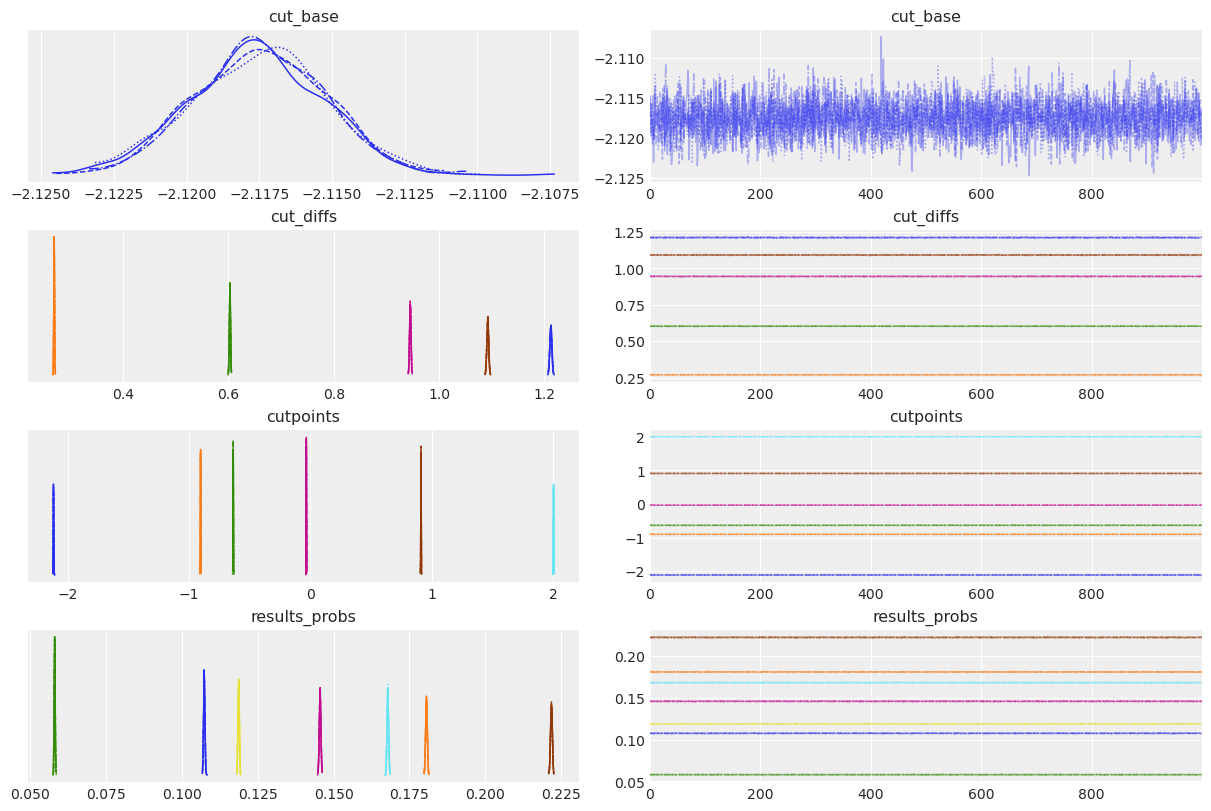

In [44]:
arviz.plot_trace(trace_simple);

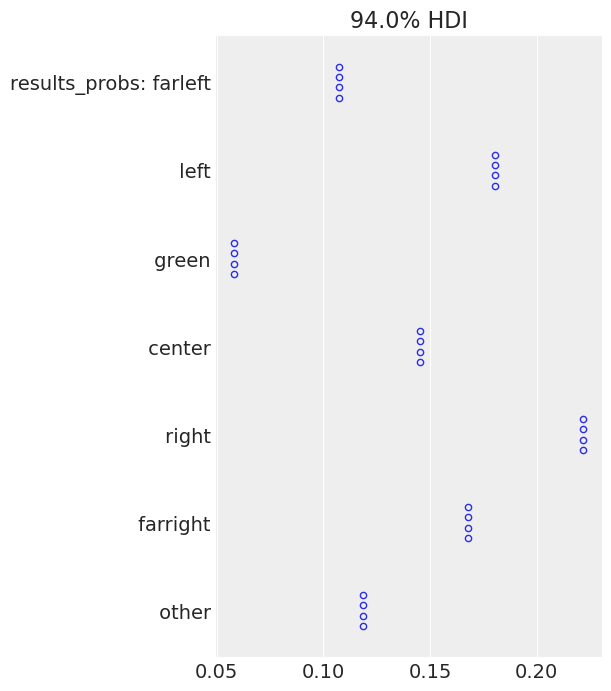

In [46]:
arviz.plot_forest(trace_simple, var_names="results_probs");

## Unpooled fundamentals model

In [8]:
region_idx, COORDS["regions"] = pd.factorize(
    subset.index.get_level_values("region"), sort=True
)

In [80]:
with pm.Model(coords=COORDS) as m_unpooled:

    initval = np.tile(
        np.arange(len(COORDS["parties"])) - 2.5, reps=(len(COORDS["regions"]), 1)
    )
    cutpoints = pm.Normal(
        "cutpoints",
        mu=initval,
        sigma=3.0,
        initval=initval,
        transform=pm.distributions.transforms.ordered,
        dims=("regions", "parties"),
    )

    pm.OrderedMultinomial(
        "results",
        eta=0,
        cutpoints=cutpoints[region_idx],
        n=subset[COORDS["parties_complete"]].sum(1).values,
        observed=subset[COORDS["parties_complete"]].values,
        dims=("observations", "parties_complete"),
    )

    trace_unpooled = pm.sample(
        random_seed=RANDOM_SEED,
        idata_kwargs=dict(
            dims={"results_probs": ["observations", "parties_complete"]},
        ),
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[18  6]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [cutpoints]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 41 seconds.


0, dim: observations, 140 =? 140


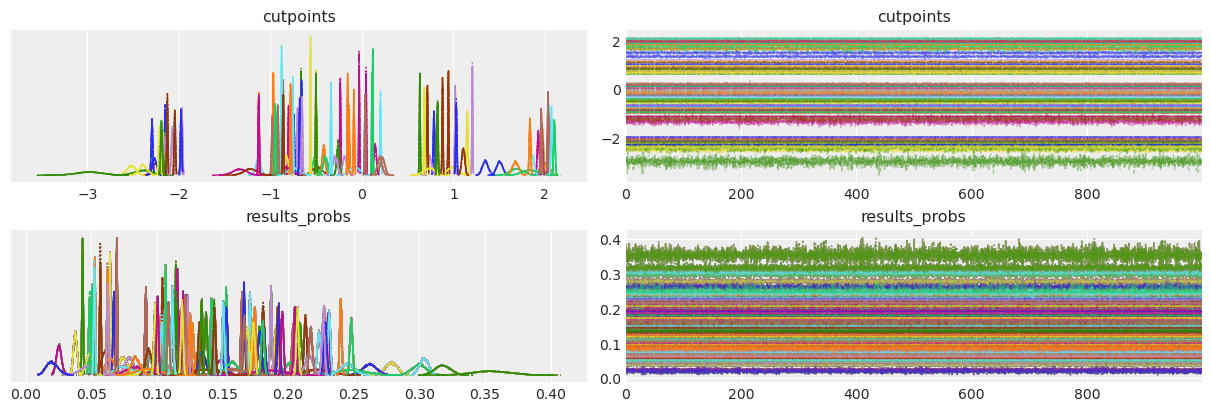

In [82]:
arviz.plot_trace(trace_unpooled);

## Hierarchical fundamentals model

In [10]:
with pm.Model(coords=COORDS) as m_hierarchical:

    init_mean = np.arange(len(COORDS["parties"])) - 2.5
    mean = pm.Normal(
        "cutpoint_mean",
        mu=init_mean,
        sigma=3.0,
        initval=init_mean,
        transform=pm.distributions.transforms.ordered,
        dims="parties",
    )
    sd = pm.HalfNormal("cutpoint_sd")

    init_cut = np.tile(
        np.arange(len(COORDS["parties"])) - 2.5, reps=(len(COORDS["regions"]), 1)
    )
    cutpoints = pm.Normal(
        "cutpoints",
        mu=mean,
        sigma=sd,
        initval=init_cut,
        transform=pm.distributions.transforms.ordered,
        dims=("regions", "parties"),
    )

    pm.OrderedMultinomial(
        "results",
        eta=0,
        cutpoints=cutpoints[region_idx],
        n=subset[COORDS["parties_complete"]].sum(1).values,
        observed=subset[COORDS["parties_complete"]].values,
        dims=("observations", "parties_complete"),
    )

    trace_hierarchical = pm.sample(
        random_seed=RANDOM_SEED,
        idata_kwargs=dict(
            dims={"results_probs": ["observations", "parties_complete"]},
        ),
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [cutpoint_mean, cutpoint_sd, cutpoints]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 33 seconds.


0, dim: observations, 51 =? 51


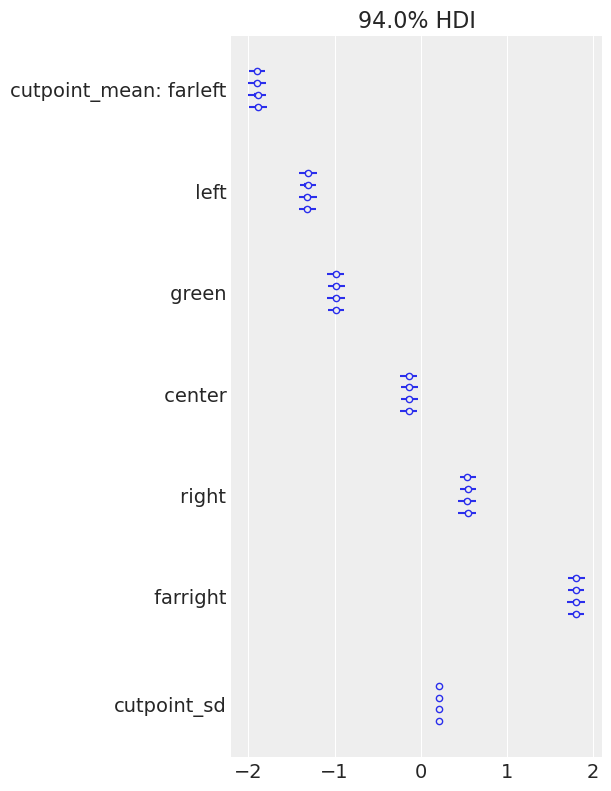

In [11]:
arviz.plot_forest(trace_hierarchical, var_names="cutpoint_", filter_vars="like");

In [15]:
def compute_p_from_cutpoints(posterior):
    # need to include eta in computation
    #   pa = sigmoid(cutpoints - at.shape_padright(eta))

    p_cum = logistic(posterior.cutpoints)

    zeros = xarray.zeros_like(p_cum.sel(parties="farleft"))
    zeros.coords["parties"] = "dummy"

    ones = xarray.ones_like(p_cum.sel(parties="farleft"))
    ones.coords["parties"] = "other"

    return xarray.concat([zeros, p_cum, ones], dim="parties").diff(dim="parties")

In [12]:
p_cum = compute_p_from_cutpoints(trace_hierarchical.posterior)

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

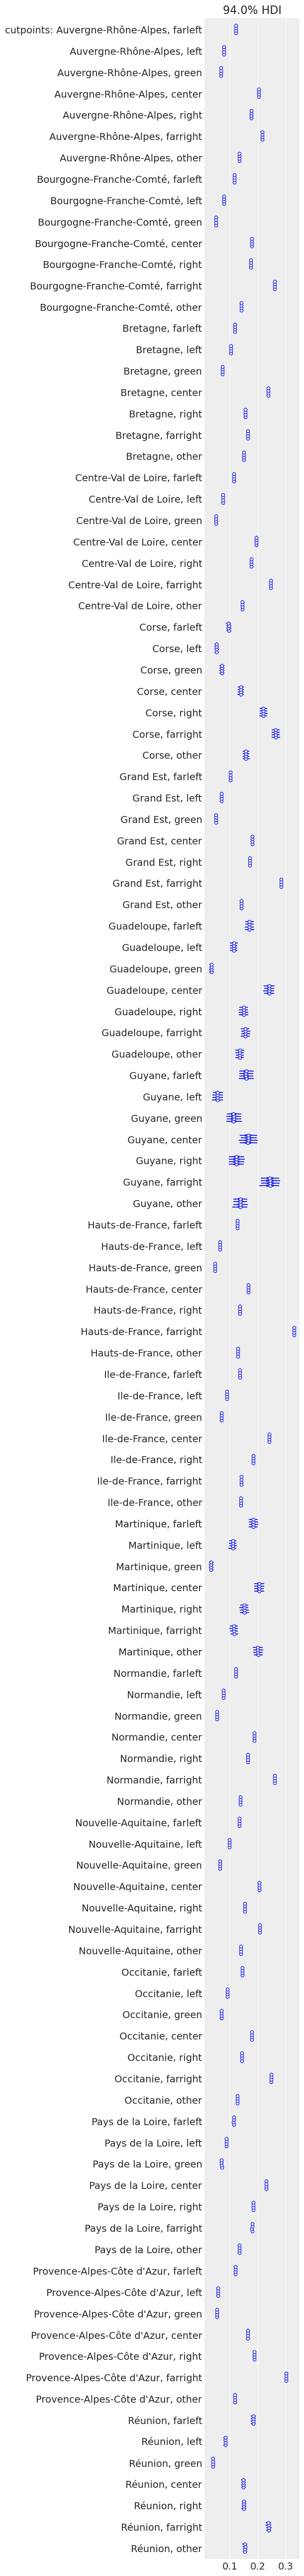

In [14]:
arviz.plot_forest(p_cum);

## Hierarchical fundamentals model with one predictor

In [9]:
unemp = pd.read_excel(
    "../../data/predictors/chomage_reg_depart_trim.xls",
    sheet_name="Région",
    header=3,
    nrows=19,
).iloc[2:]

# remove accents and special characters, then remove hyphens
unemp["normalized_region"] = unemp["Libellé"].str.lower().str.replace("-", " ").values

unemp = unemp.drop(["Code", "Libellé"], axis=1).set_index("normalized_region")

In [10]:
# as timestamps variables:
unemp.columns = pd.period_range(
    start=unemp.columns[0].split("_")[1], periods=unemp.shape[1], freq="Q"
)
unemp.columns.name = "quarter"
unemp = pd.DataFrame(unemp.stack().swaplevel(), columns=["unemployment"]).sort_index()

In [11]:
# normalize regions of data before joining
subset["normalized_region"] = (
    subset.reset_index()
    .region.str.lower()
    .str.normalize("NFKD")
    .str.encode("ascii", errors="ignore")
    .str.decode("utf-8")
    .str.replace("-", " ")
    .values
)

subset = subset.reset_index()

# add quarters to results dataframe:
subset["quarter"] = pd.DatetimeIndex(subset["election_day"].values).to_period("Q")
subset = subset.set_index(["quarter", "normalized_region"]).sort_index()

In [12]:
subset = (
    subset.merge(unemp, left_index=True, right_index=True)
    .reset_index(drop=True)
    .set_index(["election_day", "region"])
)

In [101]:
with pm.Model(coords=COORDS) as m_fundamentals:

    # hierarchical layer cutpoints
    init_mean = np.arange(len(COORDS["parties"])) - 2.5
    mean = pm.Normal(
        "cutpoint_mean",
        mu=init_mean,
        sigma=3.0,
        initval=init_mean,
        transform=pm.distributions.transforms.ordered,
        dims="parties",
    )
    sd = pm.HalfNormal("cutpoint_sd")

    # cutpoints
    init_cut = np.tile(
        np.arange(len(COORDS["parties"])) - 2.5, reps=(len(COORDS["regions"]), 1)
    )
    cutpoints = pm.Normal(
        "cutpoints",
        mu=mean,
        sigma=sd,
        initval=init_cut,
        transform=pm.distributions.transforms.ordered,
        dims=("regions", "parties"),
    )

    # regression
    regression_mean = pm.Normal("regression_mean")
    shrinkage = pm.HalfNormal("regression_shrinkage")
    bU = pm.Normal("unemp_effect", regression_mean, shrinkage, dims="regions")
    U = pm.Data("unemp_data", subset.unemployment.values)  # dims="observations"
    reg_idx = pm.Data("region_idx", region_idx)  # dims="observations"
    eta = pm.Deterministic("eta", bU[reg_idx] * U, dims="observations")

    pm.OrderedMultinomial(
        "results",
        eta=eta,
        cutpoints=cutpoints[reg_idx],
        n=subset[COORDS["parties_complete"]].sum(1).values,
        observed=subset[COORDS["parties_complete"]].values,
        dims=("observations", "parties_complete"),
    )

    trace_fundamentals = pm.sample(
        random_seed=RANDOM_SEED,
        idata_kwargs=dict(
            dims={"results_probs": ["observations", "parties_complete"]},
        ),
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [cutpoint_mean, cutpoint_sd, cutpoints, regression_mean, regression_shrinkage, unemp_effect]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 87 seconds.


0, dim: observations, 51 =? 51


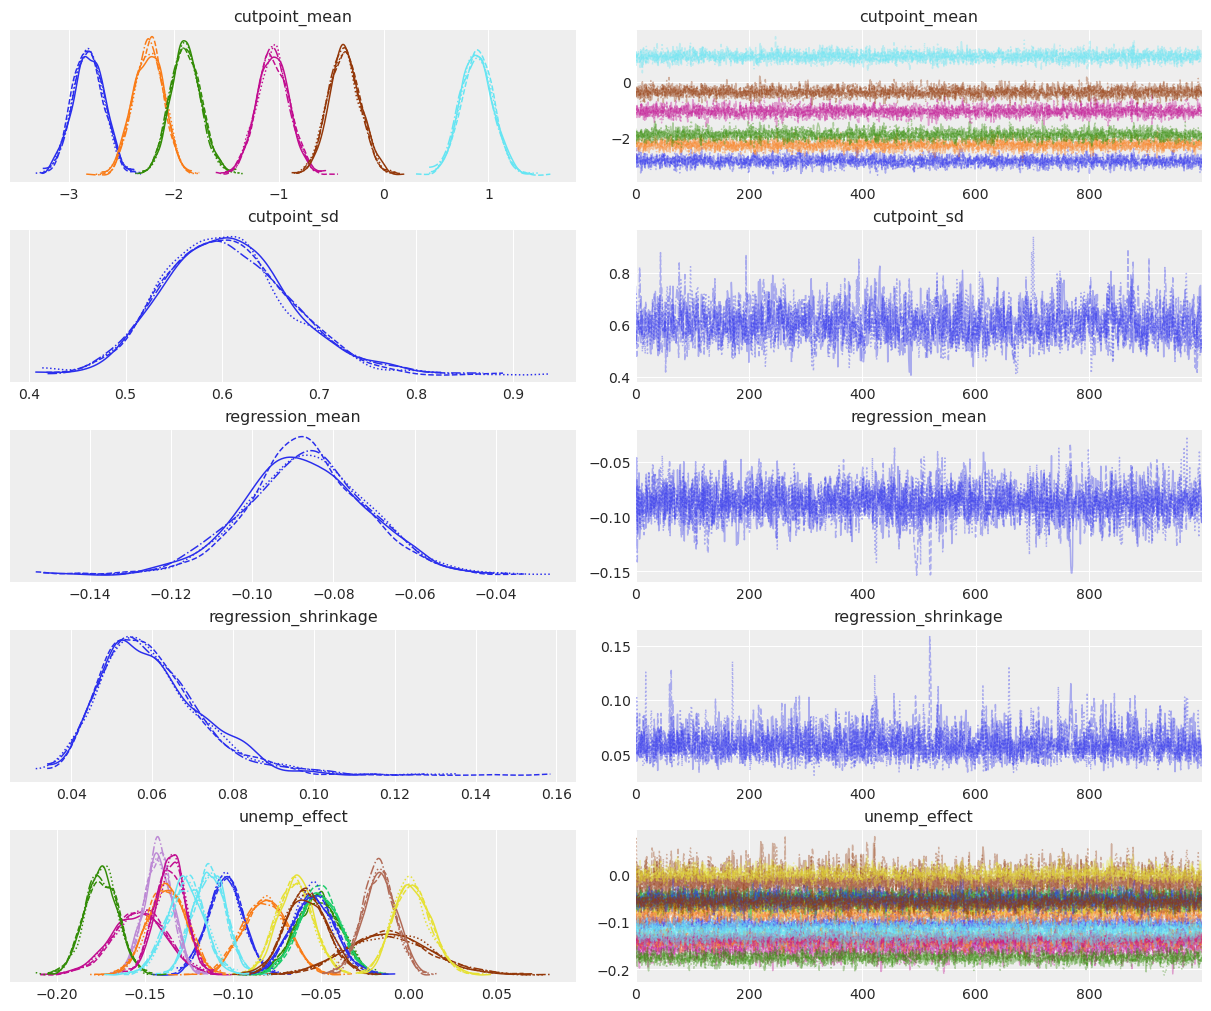

In [17]:
arviz.plot_trace(
    trace_fundamentals,
    var_names=["cutpoint_", "regression_", "unemp_effect"],
    filter_vars="like",
);

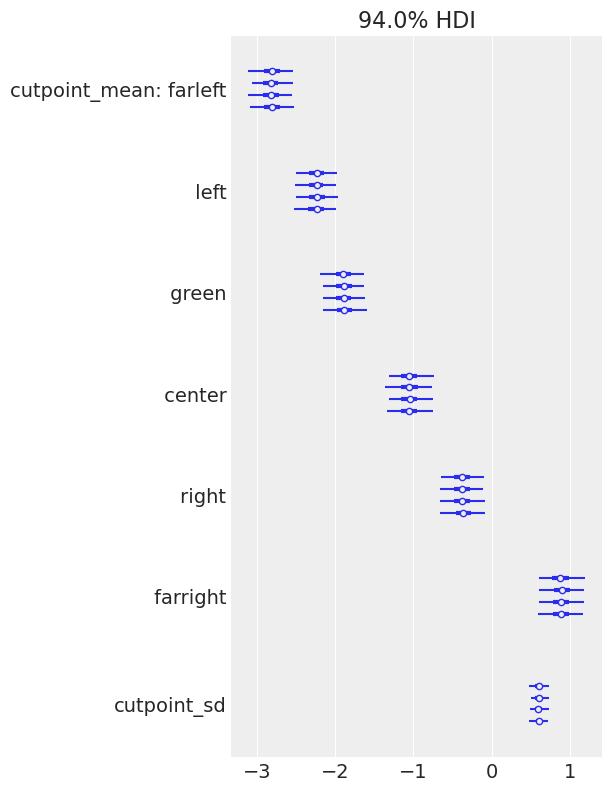

In [18]:
arviz.plot_forest(trace_fundamentals, var_names=["cutpoint_"], filter_vars="like");

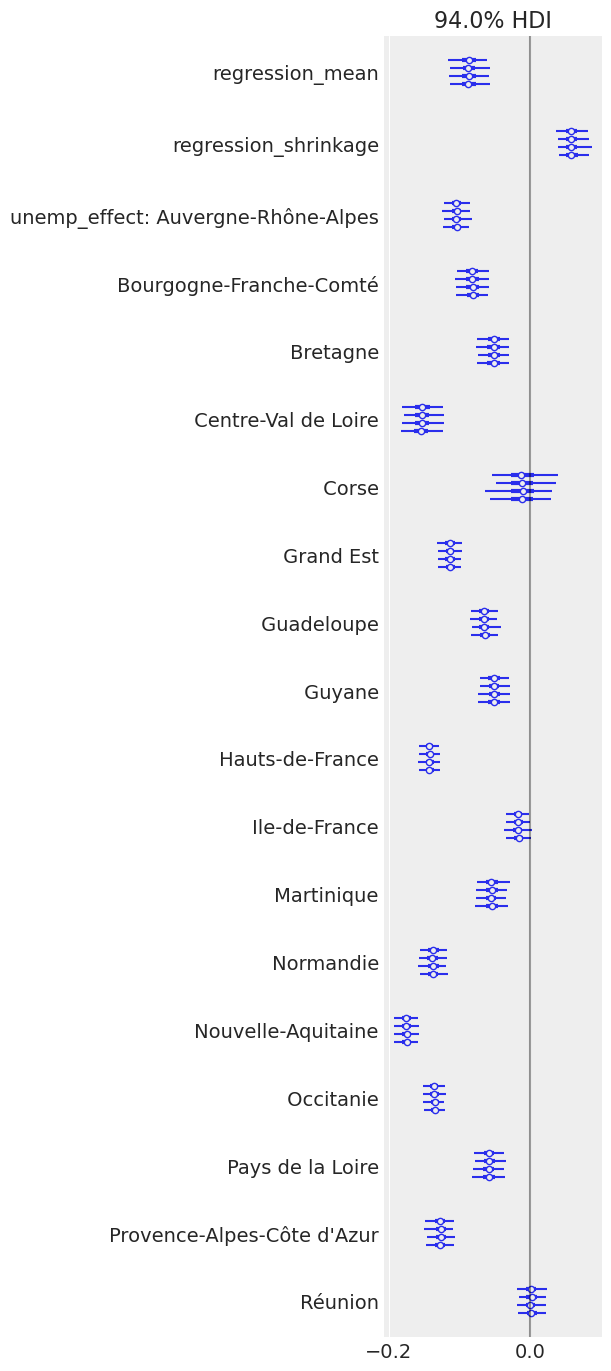

In [19]:
ax = arviz.plot_forest(
    trace_fundamentals, var_names=["regression_", "unemp_effect"], filter_vars="like"
)
ax[0].axvline(c="k", alpha=0.4);

In [20]:
ref_vals = subset[COORDS["parties_complete"]].div(
    subset[COORDS["parties_complete"]].sum(1).values, axis="rows"
)

In [21]:
ref_vals.loc[(slice(None), "Auvergne-Rhône-Alpes"), :]

,,farleft,left,green,center,right,farright,other
election_day,region,,,,,,,
2014-05-25,Auvergne-Rhône-Alpes,0.061463,0.136584,0.101036,0.099272,0.217855,0.238162,0.145629
2017-04-23,Auvergne-Rhône-Alpes,0.192363,0.061255,0.000000,0.244973,0.202011,0.207169,0.092229
2019-05-26,Auvergne-Rhône-Alpes,0.057686,0.059939,0.149698,0.226537,0.103804,0.209937,0.192399


In [22]:
trace_fundamentals.posterior["results_probs"].sel(
    observations=[
        ("2014-05-25", "Auvergne-Rhône-Alpes"),
        ("2017-04-23", "Auvergne-Rhône-Alpes"),
        ("2019-05-26", "Auvergne-Rhône-Alpes"),
    ]
).mean(("chain", "draw")).to_dataframe().unstack()

results_probs                                \
parties_complete                        farleft      left     green    center   
election_day region                                                             
2014-05-25   Auvergne-Rhône-Alpes      0.128062  0.083051  0.071192  0.206936   
2017-04-23   Auvergne-Rhône-Alpes      0.122358  0.080212  0.069305  0.204366   
2019-05-26   Auvergne-Rhône-Alpes      0.112648  0.075208  0.065872  0.199208   

                                                                 
parties_complete                      right  farright     other  
election_day region                                              
2014-05-25   Auvergne-Rhône-Alpes  0.175208  0.208430  0.127121  
2017-04-23   Auvergne-Rhône-Alpes  0.176504  0.214246  0.133009  
2019-05-26   Auvergne-Rhône-Alpes  0.178273  0.224596  0.144195

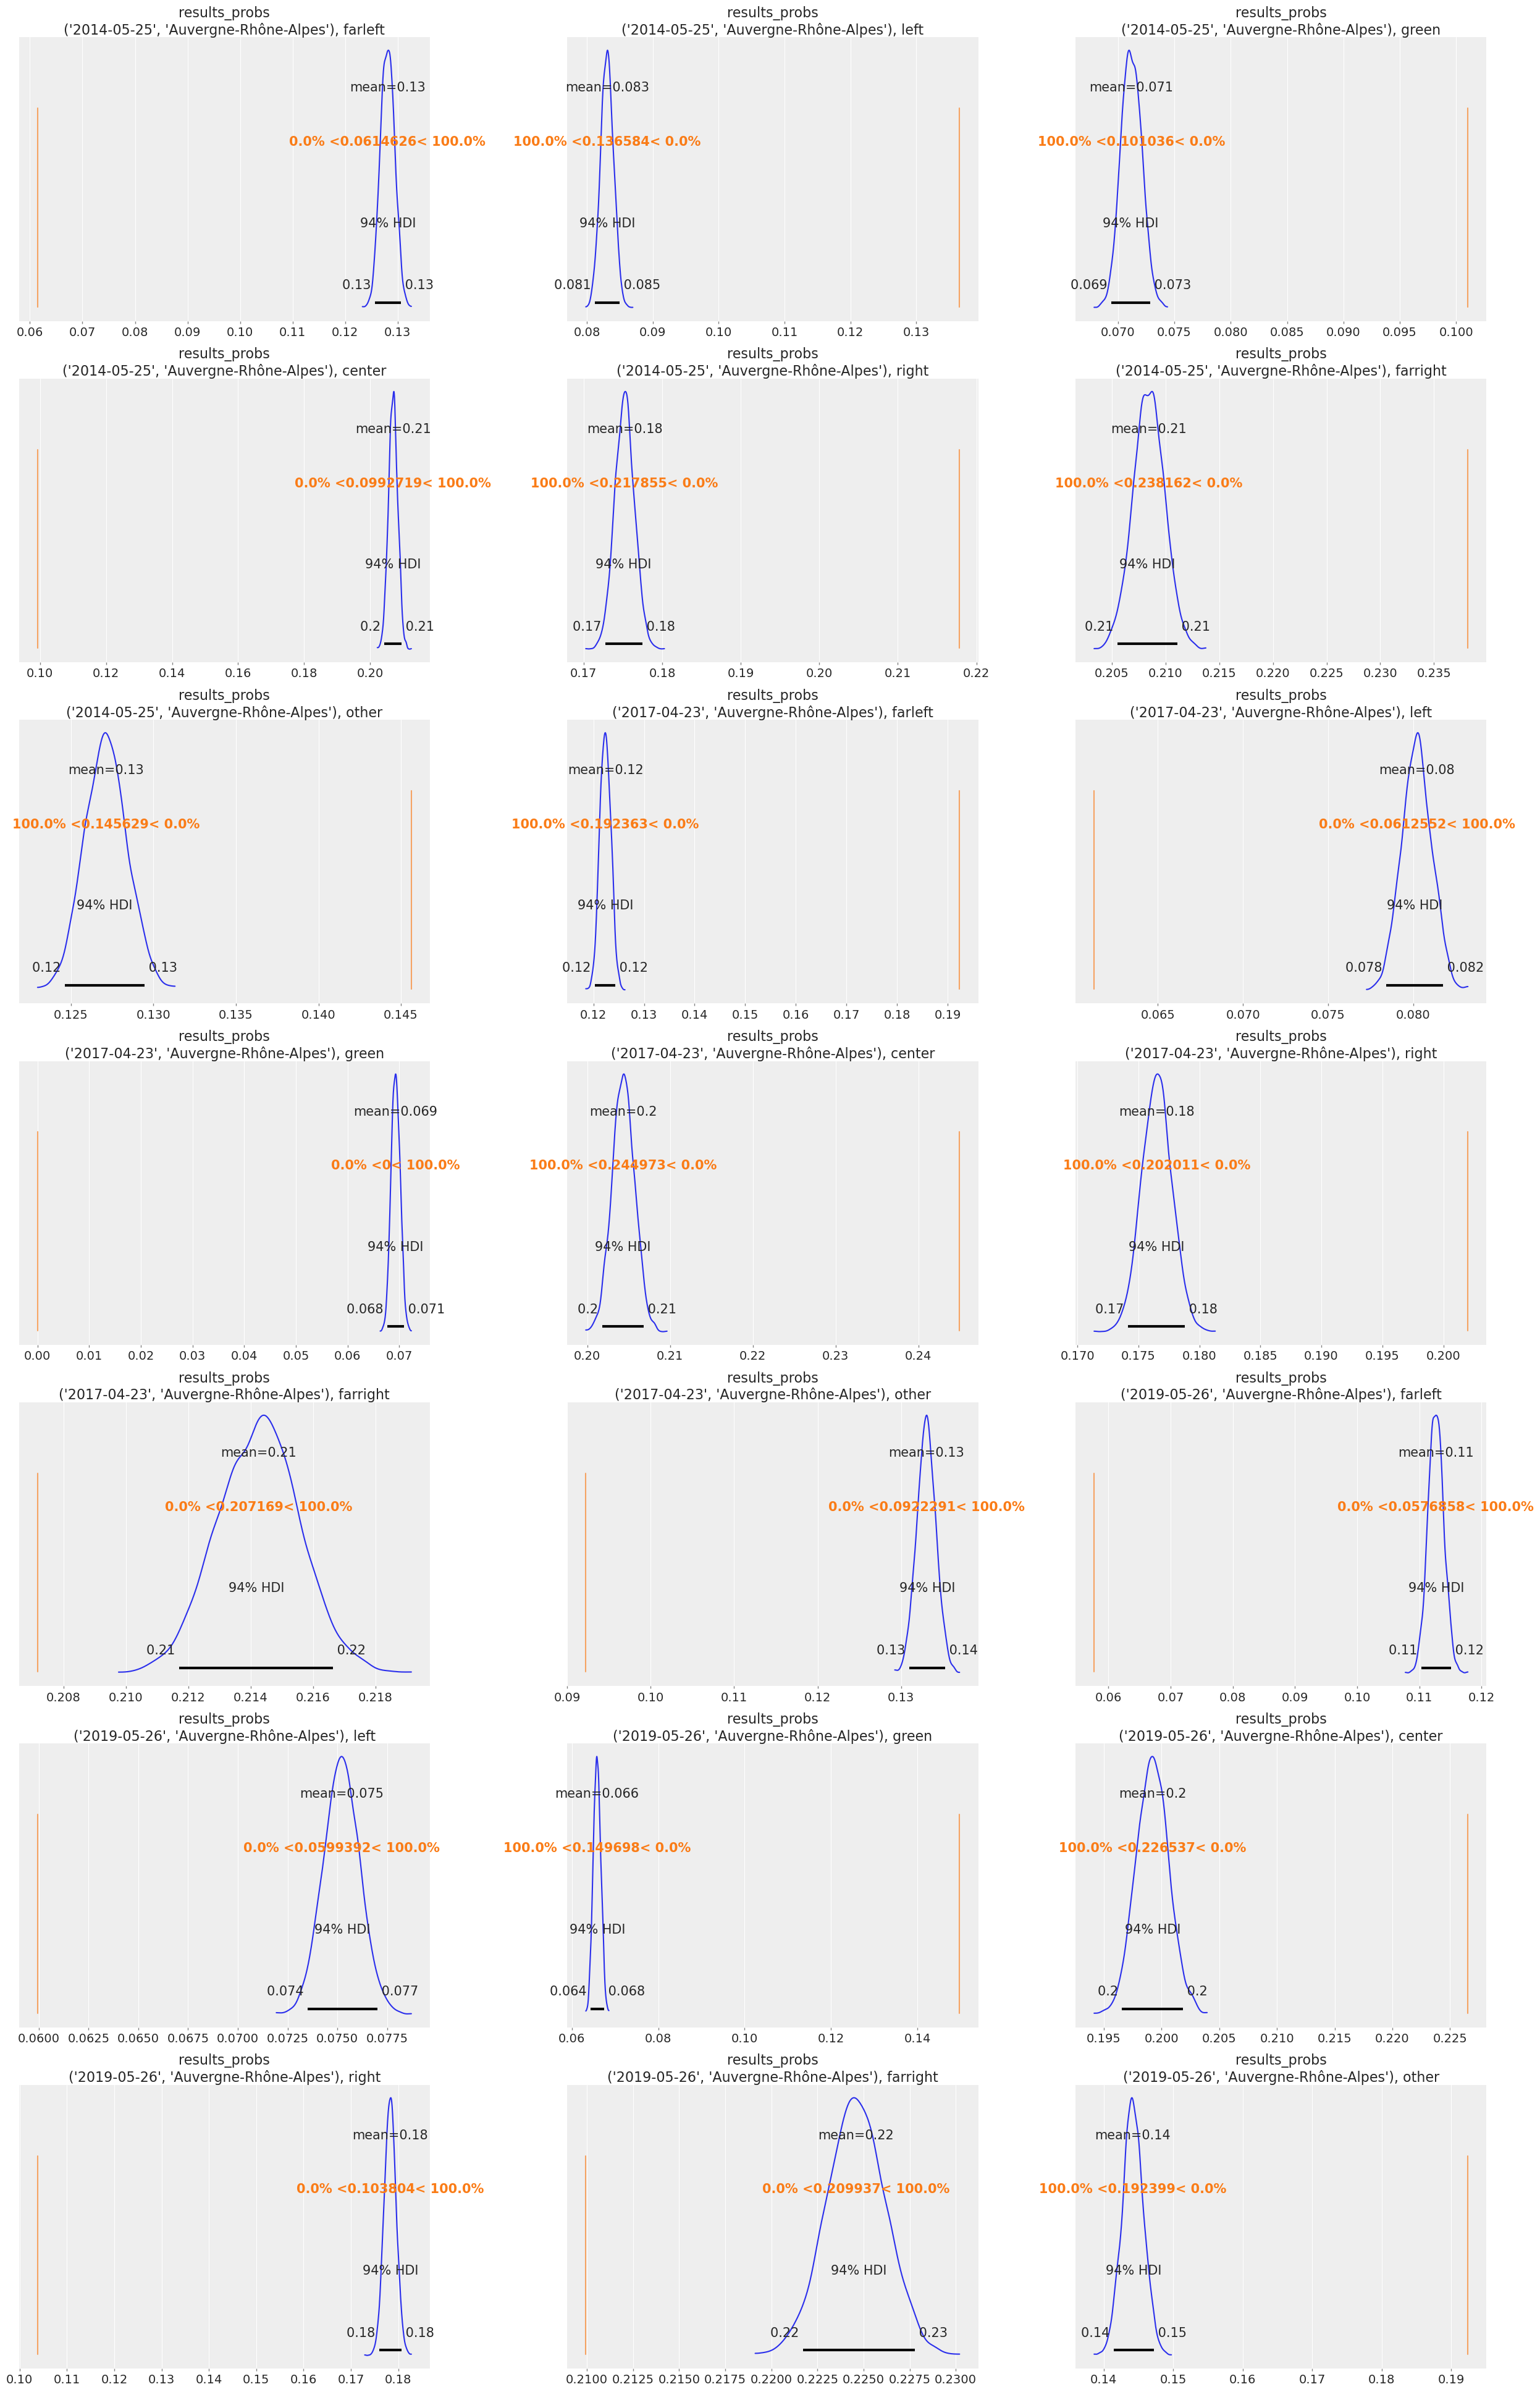

In [23]:
arviz.plot_posterior(
    trace_fundamentals,
    var_names="results_probs",
    coords={
        "observations": [
            ("2014-05-25", "Auvergne-Rhône-Alpes"),
            ("2017-04-23", "Auvergne-Rhône-Alpes"),
            ("2019-05-26", "Auvergne-Rhône-Alpes"),
        ]
    },
    ref_val=ref_vals.loc[(slice(None), "Auvergne-Rhône-Alpes"), :].stack().tolist(),
);

## Out-of-sample prediction

To be used as priors for each region and party in the dynamic model.

In [118]:
latest_update = unemp.sort_index().index.get_level_values(0)[-1]
latest_U = unemp.sort_index().loc[latest_update, :].values.squeeze()

In [103]:
with m_fundamentals:
    pm.set_data(
        {"unemp_data": latest_U, "region_idx": np.arange(len(COORDS["regions"]))}
    )
    post_pred = pm.sample_posterior_predictive(
        trace_fundamentals, var_names=["eta", "cutpoints"]
    )

In [174]:
p_cum = logistic(post_pred["cutpoints"] - post_pred["eta"][..., None])
p_cum = np.c_[
    np.zeros_like(p_cum[..., 0][..., None]),
    p_cum,
    np.ones_like(p_cum[..., 0][..., None]),
]
post_probs = xarray.DataArray(
    p_cum[..., 1:] - p_cum[..., :-1],
    dims=["samples", "regions", "parties_complete"],
    coords={
        "samples": np.arange(p_cum.shape[0]),
        "regions": COORDS["regions"],
        "parties_complete": COORDS["parties_complete"],
    },
)

In [178]:
post_probs.mean("samples")

<xarray.DataArray (regions: 17, parties_complete: 7)>
array([[0.12656514, 0.07028519, 0.05937612, 0.17289791, 0.15160049,
        0.23631317, 0.18296198],
       [0.10708404, 0.06197504, 0.05382133, 0.16265403, 0.15108637,
        0.25093529, 0.2124439 ],
       [0.09006373, 0.05430731, 0.04819008, 0.15060826, 0.14779985,
        0.26432284, 0.24470793],
       [0.1689877 , 0.08613644, 0.0690912 , 0.18627161, 0.14780152,
        0.20407813, 0.13763339],
       [0.07203319, 0.04551822, 0.04061623, 0.13447501, 0.14109736,
        0.27518536, 0.29107461],
       [0.14265887, 0.07665991, 0.06374865, 0.17936238, 0.15091871,
        0.22373037, 0.1629211 ],
       [0.19491154, 0.09372572, 0.07301199, 0.18929838, 0.14202986,
        0.18756137, 0.11946113],
       [0.16449776, 0.08479089, 0.0678306 , 0.18380343, 0.14641572,
        0.20852223, 0.14413936],
       [0.20313876, 0.0958272 , 0.07477895, 0.19135601, 0.14071285,
        0.18131786, 0.11286837],
       [0.07508181, 0.04672122, 0.04225785, 0.13799079, 0.1418778 ,
        0.27508772, 0.28098282],
       [0.13009923, 0.07157834, 0.06005343, 0.17387889, 0.15086274,
        0.23387603, 0.17965132],
       [0.16606681, 0.08445317, 0.06898102, 0.18508316, 0.14780436,
        0.20720442, 0.14040707],
       [0.19318222, 0.09389688, 0.07354798, 0.19017199, 0.14270681,
        0.18756979, 0.11892432],
       [0.19376518, 0.09356868, 0.07392931, 0.18944903, 0.14326848,
        0.18741767, 0.11860165],
       [0.0946003 , 0.0563763 , 0.04960706, 0.15417897, 0.14840697,
        0.26125944, 0.23557096],
       [0.17446625, 0.08767309, 0.07031546, 0.18759329, 0.14598792,
        0.20061569, 0.1333483 ],
       [0.0654172 , 0.04125295, 0.03809779, 0.12774045, 0.13653596,
        0.27815973, 0.31279592]])
Coordinates:
  * regions           (regions) object 'Auvergne-Rhône-Alpes' ... 'Réunion'
  * parties_complete  (parties_complete) <U8 'farleft' 'left' ... 'other'

In [180]:
arviz.to_netcdf(post_probs, "fundamentals_preds.nc")

'fundamentals_preds.nc'

In [181]:
%load_ext watermark
%watermark -a AlexAndorra -n -u -v -iv

Author: AlexAndorra

Last updated: Fri Jul 09 2021

Python implementation: CPython
Python version       : 3.9.4
IPython version      : 7.24.1

pymc3     : 4.0
matplotlib: 3.4.2
numpy     : 1.20.3
scipy     : 1.6.3
aesara    : 2.0.10
arviz     : 0.11.2
xarray    : 0.18.2
pandas    : 1.2.4
seaborn   : 0.11.1

